# Contenido

1. **Carga de librerías y datos**
    - 1.a. Librerías
    - 1.b. Funciones
    - 1.c. Carga de datos
2. **Modelado**
    - 2.a. Creación variables exógenas
    - 2.b. Entrenamiento del modelo
    - 2.c. Evaluación


# 1. Carga de librerías y datos

##  1.a. Librerías

In [1]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelado y Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap

from IPython.display import Image
import plotly.io as pio

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión lightgbm: {lightgbm.__version__}")
print(f"{color}Versión xgboost: {xgboost.__version__}")
print(f"{color}Versión catboost: {catboost.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión scikit-learn: 1.6.0
Versión lightgbm: 4.5.0
Versión xgboost: 2.1.3
Versión catboost: 1.2.7
Versión pandas: 2.2.3
Versión numpy: 1.26.4



##  1.b. Funciones


In [2]:
def train_val_test(datos, fin_train, fin_val):
    # Separación de datos en entrenamiento, validación y test
    # ==============================================================================
    datos_train = datos.loc[: fin_train]
    datos_val   = datos.loc[fin_train:fin_val]
    datos_test  = datos.loc[fin_val:]
    print(
        f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  "
        f"(n={len(datos_train)})"
    )
    print(
        f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  "
        f"(n={len(datos_val)})"
    )
    print(
        f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  "
        f"(n={len(datos_test)})"
    )
    return datos_train, datos_val, datos_test

def imputar_nulos_por_hora(datos):
    datos.index = pd.to_datetime(datos.index)
    horas = datos.index.hour
    
    # Promedio por hora y sustitución el valores Nan
    media_por_hora = datos.groupby(horas).transform('mean')
    datos = datos.fillna(media_por_hora)
    
    return datos

##  1.c. Carga de datos

Datos BICING:

In [3]:
df = pd.read_parquet('../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/BICICLETAS_HORARIO_2022_2023_FILTRADO.parquet')
datos = df[494]
datos = imputar_nulos_por_hora(datos)

In [4]:
fin_train = '2023-04-30 23:59:00'
fin_val = '2023-09-30 23:59:00'

datos_train, datos_val, datos_test = train_val_test(datos, fin_train, fin_val)

Fechas train      : 2022-01-01 00:00:00 --- 2023-04-30 23:00:00  (n=11640)
Fechas validación : 2023-05-01 00:00:00 --- 2023-09-30 23:00:00  (n=3672)
Fechas test       : 2023-10-01 00:00:00 --- 2023-12-31 23:00:00  (n=2208)


#  2. Modelado

## 2.a. Creación variables exógenas

In [5]:
from Creacion_exog import calculo_variables_exogenas

In [6]:
# Convertir la serie a un DataFrame con el índice como FECHA
datos = datos.to_frame(name='CANTIDAD')
datos.index = pd.to_datetime(datos.index)
datos = datos.asfreq('H')
datos.index.name = 'FECHA'

variables_exogenas = calculo_variables_exogenas(datos)

In [7]:
# Transformación: codificación ordinal + conversión a tipo "category"
# ==============================================================================
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [8]:
# Selección de variables exógenas a incluir en el modelo
# ==============================================================================
exog_cols = []
# Columnas que terminan con _seno o _coseno son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='_seno$|_coseno$').columns.tolist())
# Columnas que empiezan con festivo_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^festivo_.*').columns.tolist())
exog_cols.extend(['FESTIVO'])

variables_exogenas = variables_exogenas.filter(exog_cols, axis=1)
variables_exogenas.head(3)

,mes_seno,mes_coseno,semana_anyo_seno,semana_anyo_coseno,dia_semana_seno,dia_semana_coseno,hora_dia_seno,hora_dia_coseno,hora_amanecer_seno,hora_amanecer_coseno,...,poly_hora_dia_coseno__hora_anochecer_coseno,poly_hora_amanecer_seno__hora_amanecer_coseno,poly_hora_amanecer_seno__hora_anochecer_seno,poly_hora_amanecer_seno__hora_anochecer_coseno,poly_hora_amanecer_coseno__hora_anochecer_seno,poly_hora_amanecer_coseno__hora_anochecer_coseno,poly_hora_anochecer_seno__hora_anochecer_coseno,festivo_dia_anterior,festivo_dia_siguiente,FESTIVO
FECHA,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.5,0.866025,0.0,1.0,-0.781831,0.62349,0.258819,0.965926,0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
2022-01-01 01:00:00,0.5,0.866025,0.0,1.0,-0.781831,0.62349,0.500000,0.866025,0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
2022-01-01 02:00:00,0.5,0.866025,0.0,1.0,-0.781831,0.62349,0.707107,0.707107,0.866025,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [9]:
# Combinar variables exógenas y target en el mismo dataframe
# ==============================================================================
datos = datos[['CANTIDAD']].merge(
    variables_exogenas,
    left_index=True,
    right_index=True,
    how='left'
)

# Debido a la creación de medias móviles, hay valores NaN al principio de la serie.
# Debido a holiday_dia_siguiente hay valores NaN al final de la serie.
# Las columnas numéricas se convierten a float32.
datos = datos.dropna()
datos = datos.astype({col: np.float32 for col in datos.select_dtypes("number").columns})
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_val, :].copy()
datos_test  = datos.loc[fin_val:, :].copy()

## 2.b. Entrenamiento del modelo

**LGBMRegressor**

In [10]:
%%time

# Búsqueda de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 24,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Lags grid
lags_grid = [24, 48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_val, 'CANTIDAD'],
    exog               = datos.loc[:fin_val, exog_cols],
    search_space       = search_space,
    steps              = 8,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
best_params = results_search['params'].iat[0]

Best trial: 7. Best value: 2.10682: 100%|██████████| 20/20 [05:37<00:00, 16.87s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 1200, 'max_depth': 9, 'min_data_in_leaf': 195, 'learning_rate': 0.03135981726152987, 'feature_fraction': 0.6, 'max_bin': 125, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 1.0}
  Backtesting metric: 2.106815527364998

CPU times: total: 20min 8s
Wall time: 5min 42s


In [11]:
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")
# Backtesting en los datos de test incluyendo las variables exógenas
# ==============================================================================
metrica_LGBMRegressor, predicciones_lgbm = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['CANTIDAD'],
    exog               = datos[exog_cols],
    steps              = 8,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_val]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_LGBMRegressor

100%|██████████| 273/273 [00:10<00:00, 24.91it/s]


,mean_absolute_error
0,2.713031


**XGBRegressor**

In [12]:
# Encoding ordinal + conversión a tipo category
# ==============================================================================
pipeline_categorical = make_pipeline(
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        FunctionTransformer(
            func=lambda x: x.astype('category'),
            feature_names_out= 'one-to-one'
        )
    )

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_exclude=np.number)
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [13]:
%%time
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = XGBRegressor(tree_method="hist", enable_categorical=True, random_state=123),
    lags             = 24,
    transformer_exog = transformer_exog,
)


def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_val, 'CANTIDAD'],
    exog               = datos.loc[:fin_val, exog_cols],
    search_space       = search_space,
    steps              = 8,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

Best trial: 12. Best value: 2.0557: 100%|██████████| 20/20 [09:33<00:00, 28.68s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.012466309356226113, 'subsample': 0.9566174938835406, 'colsample_bytree': 0.950197921108696, 'gamma': 0.009720202192849692, 'reg_alpha': 0.003677635938921009, 'reg_lambda': 0.7462071981396059}
  Backtesting metric: 2.0557006236393014

CPU times: total: 59min 25s
Wall time: 9min 50s


In [14]:
# Backtesting con datos de test
# ==============================================================================
metrica_xgboost, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['CANTIDAD'],
    exog               = datos[exog_cols],
    steps              = 8,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_val]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_xgboost

100%|██████████| 273/273 [00:11<00:00, 24.62it/s]


,mean_absolute_error
0,2.628752


**CatBoost**

In [15]:
# One hot encoding
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_exclude=np.number),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = CatBoostRegressor(
                    random_state=123, 
                    silent=True, 
                    allow_writing_files=False,
                    boosting_type = 'Plain', # Faster training
                    leaf_estimation_iterations = 3, # Faster training
                ),
    lags = 24,
    transformer_exog = one_hot_encoder
)

In [16]:
%%time
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_val, 'CANTIDAD'],
    exog               = datos.loc[:fin_val, exog_cols],
    search_space       = search_space,
    steps              = 8,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

Best trial: 15. Best value: 2.10996: 100%|██████████| 20/20 [11:38<00:00, 34.94s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.4635401515831307}
  Backtesting metric: 2.1099648124768238

CPU times: total: 38min 22s
Wall time: 11min 39s


In [17]:
# Backtesting con datos de test
# ==============================================================================
metrica_catboost, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['CANTIDAD'],
    exog               = datos[exog_cols],
    steps              = 8,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_val]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_catboost

100%|██████████| 273/273 [00:07<00:00, 36.38it/s]


,mean_absolute_error
0,2.644711


In [18]:
print(f'Métrica LightGBM: {metrica_LGBMRegressor}')
print(f'Métrica Xgboost: {metrica_xgboost}')
print(f'Métrica Catboost: {metrica_catboost}')

Métrica LightGBM:    mean_absolute_error
0             2.713031
Métrica Xgboost:    mean_absolute_error
0             2.628752
Métrica Catboost:    mean_absolute_error
0             2.644711


## 2.c. Evaluación 

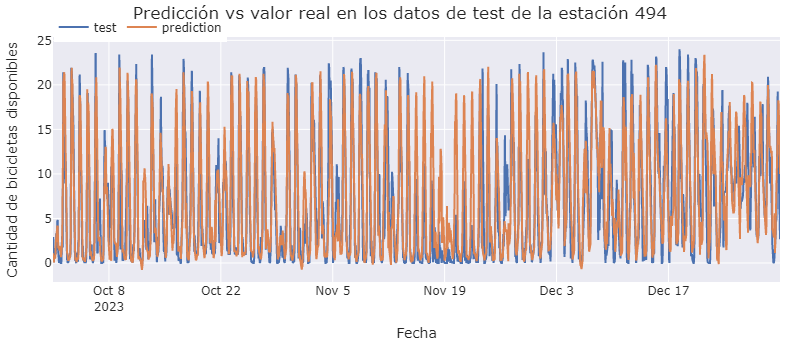

In [19]:
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*setDaemon.*")
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['CANTIDAD'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones_lgbm.index, y=predicciones_lgbm['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test de la estación 494",
    xaxis_title="Fecha",
    yaxis_title="Cantidad de bicicletas disponibles",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
# fig.show() # Muestra la imagen en formato interactivo

static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática

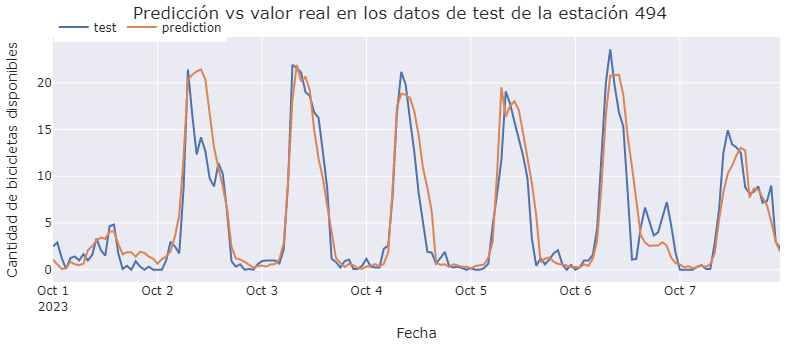

In [20]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index[0:168], y=datos_test['CANTIDAD'][0:168], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones_lgbm.index[0:168], y=predicciones_lgbm['pred'][0:168], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test de la estación 494",
    xaxis_title="Fecha",
    yaxis_title="Cantidad de bicicletas disponibles",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
# fig.write_image("predicción_494.png")
# fig.show() # Muestra la imagen en formato interactivo

static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática